# 한국 SW중심대학 공동 AI 경진대회 <본선>
## 최종코드 제출
## Team: 한림대학교
## private score: 5위
* 안녕하세요, 한림대학교 팀입니다. 저희는 한림대학교 학부생 동기 5인으로 구성되어 있으며 대회에 참가하면서 좋은 경험을 했습니다. 감사합니다. 아래는 score 재현 방법입니다.
---


# 1. 기본 셋팅
## 외부 사용 데이터
## **아래 데이터셋을 `TIW` 으로 칭합니다.**
[AIHUB: 한국어 글자체 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=81) </br>

## **아래 데이터셋을 `HUB` 으로 칭합니다.**
[AIHUB: 야외 실제 촬영 한글 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=105) </br>

## **데이콘이 제공한 데이터셋을 `TRAIN`과 `TEST`로 칭합니다.**


### 파일 경로 설정 방법: ./customocr
├── <b>hallymocr: *학습에 필요한 모듈들*</b></br>
│   ├── modules</br>
│   │   └── \_\_pycache__</br>
│   └── \_\_pycache__</br>
├── images: *학습에 사용되는 이미지 파일*</br>
│   ├── crop_tiw : *크롭된 `HUB` 이미지*</br>
│   ├── crop_train : *크롭된 `TIW` 이미지*</br>
│   ├── hub_train : *`HUB`이미지*</br>
│   ├── test : *`TEST`이미지*</br>
│   ├── tiw : *`TIW` 원본이미지*</br>
│   └── train : *`TRAIN` 원본이미지*</br>
├── labels: *라벨 및 이미지 정보가 담긴 json파일*</br>
│   ├── hub_train : *`HUB` json파일*</br>
│   └── tiw : *`TIW` json파일*</br>
├── lmdb_gt: *lmdb생성을 위한 txt파일*</br>
├── result: *생성된 lmdb파일*</br>
│   ├── htrain: *`HUB` lmdb*</br>
│   ├── tiw: *`TIW` lmdb*</br>
│   ├── train: *`TRAIN[:-1000]`*</br>
│   └── valid: *`TRAIN[-1000:]`*</br>
├── saved_models: *모델 및 로그 저장*</br>
│   └── TPS-ResNet-BiLSTM-Attn-Seed1111</br>
├── <b>ocr.ipynb: *핵심 실행 파일(main)*</b></br>
├── README.md</br>
├── requirements.yaml</br>
└── train_edit.csv: 수작업으로 정제된 `TRAIN` csv파일</br>


## 1-1. git pull하기
```linux
git pull https://github.com/mhseo10/customocr
```

## 1-2. AI_HUB에서 데이터 다운로드 받기 </br>
[한국어 글자체 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=81) </br>
[야외 실제 촬영 한글 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=105)

## 1-3. 이미지 및 json파일 저장 (★★)
### 한국어 글자체 이미지 (`TIW`)
- ★ 중요 ★4개의 카테고리중 `Text in the wild` 데이터셋만 사용
- 이미지 파일:  `./images/tiw`에 저장하며, 이때 `Text in the wild`데이터 셋 안에 4개의 폴더가 있는데, 이를 각 폴더로 두지 않고 각 폴더안에 있는 image파일들을 `./tiw`에 한 곳으로 저장해야합니다.
- json 파일: `TIW` 데이터셋은 하나의 json파일로 라벨링이 이루어져 있습니다.
    - ex) 100만장의 image, 1개의 json파일
    - 이때 json파일은 `textinthewild_data_info.json`입니다. 
    - `./labels/tiw`에 저장합니다.
### 야외 실제 촬영 한글 이미지 (`HUB`)
- `HUB`셋은 Train셋과 Validation셋이 존재하나 Train셋만 사용합니다.
- 이미지 파일: `./images/hub_train`에 저장하며 이때 `TIW`와 다르게 다운된 폴더 구조 째로 넣어주시면 됩니다.
- json 파일: KOREAN 데이터셋은 하나의 image에 하나의 json파일이 각각 매치되어있습니다.
    - ex) 100만장의 image, 100만개의 json파일
    - [원천]과 [라벨]로 이름이 지정되어있습니다. [원천]의 이름에 맞게 [라벨]에 json파일이 매치되어있습니다.
    - `./labels/hub_train`에 저장합니다.

In [ ]:
# deep-text-recognition-benchmark의 dependency 설치
# !pip install lmdb pillow torchvision nltk natsort fire

In [ ]:
# 대회 목적에 맞게 수정한 ocr 클론
# !git clone https://github.com/seongjiko/customocr.git

## 2. AI허브 데이터셋 전처리
`HUB`의 validation셋은 사용하지 않습니다.

In [1]:
hub_timg = './images/hub_train/'
hub_tlabel = './labels/hub_train/' 

# hub_vimg = './images/hub_valid/'
# hub_vlabel = './labels/hub_valid/'

train_img = './images/train/'
train_label = './labels/train/'

tiw_img = './images/tiw/'
tiw_label = './labels/tiw/'

test_img = './images/test/'

hub_tcrop = './images/crop_train/'
hub_vcrop = './images/crop_valid/'
tiw_crop = './images/crop_tiw/'

lmdb_gt = './lmdb_gt/'

### 2-1. [한국어 글자체 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=81)

In [29]:
import os
import glob
import json
import natsort
import pandas as pd

from tqdm.auto import tqdm, trange
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

### 파일 경로, 이미지, 라벨 추출

In [30]:
data = json.load(open(tiw_label + 'textinthewild_data_info.json', encoding='utf8'))  # json 경로로 변경

In [31]:
data.__len__(), data.keys()

(4, dict_keys(['info', 'images', 'annotations', 'licenses']))

In [32]:
img_path = dict()
img_path_li = []
no_img = []

for idx, info in tqdm(enumerate(data['images']), total=len(data['images'])):
    img_path[data['images'][idx]["id"]] = data['images'][idx]["file_name"]
    img_path_li.append(data['images'][idx]["file_name"][:-4])

img_path.__len__()

100%|██████████| 100271/100271 [00:00<00:00, 905368.17it/s]


100271

In [34]:
file_path_li = []

for (path, dir, files) in os.walk(tiw_img):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        index_number = filename.split('.')[0]
        file_path_li.append(index_number)

file_path_li.__len__()

1000

In [ ]:
# image 파일과 json 파일의 개수가 다르기 때문에 (data, label) 쌍이 맞지 않는 데이터 제거

liset = set(file_path_li)
li2set = set(img_path_li)
black_list = set(liset | li2set) - set(liset & li2set)
black_list.__len__()

In [37]:
path = []
text = []
bbox = []

for idx, info in tqdm(enumerate(data['annotations']), total=len(data['annotations'])):

    # label 결측치 제거
    if data['annotations'][idx]['text'] == None:
        continue
    if img_path[data['annotations'][idx]['image_id']][:-4] in black_list:
        continue

    # 좌표 이상치 제거
    if data['annotations'][idx]['bbox'][2] + data['annotations'][idx]['bbox'][0] <= data['annotations'][idx]['bbox'][0]:
        continue
    if data['annotations'][idx]['bbox'][3] + data['annotations'][idx]['bbox'][1] <= data['annotations'][idx]['bbox'][1]:
        continue

    # 데이터 추가
    path.append(data['annotations'][idx]['image_id'])
    text.append(data['annotations'][idx]['text'])
    bbox.append(data['annotations'][idx]['bbox'])

len(path), len(text), len(bbox)

100%|██████████| 2097591/2097591 [00:01<00:00, 1683368.32it/s]


(15580, 15580, 15580)

### 데이터 전처리(Crop)

In [38]:
# json의 저장 순서는 (x, y, width, height)
# PIL의 Image.crop()과 순서는 동일하지만, (width, height)를 크기가 아닌 좌표로 변환하는 작업 필요

for i in trange(len(bbox)):
    bbox[i][2] = bbox[i][0] + bbox[i][2]
    bbox[i][3] = bbox[i][1] + bbox[i][3]

100%|██████████| 15580/15580 [00:00<00:00, 625320.63it/s]


In [39]:
alpha = 0.5  # 이미지 resize 비율
starts = 0  # 오류로 중단하기 전 마지막 인덱스 추후 매치가 되지않아 오류 발생시 해결후 그 idx를 starts에 넣고 재실행

for idx, i in tqdm(enumerate(bbox[starts:]), total=len(bbox[starts:])):
    idx += starts
    image = Image.open(tiw_img + img_path[path[idx]])
    crop_image = image.crop(i)

    # crop_image.resize((crop_image.size[0] * alpha, crop_image.size[1] * alpha))  # resize
    crop_image.save(tiw_crop + f'train_data_{idx}.jpg')

100%|██████████| 15580/15580 [06:32<00:00, 39.71it/s]


### 데이터 저장

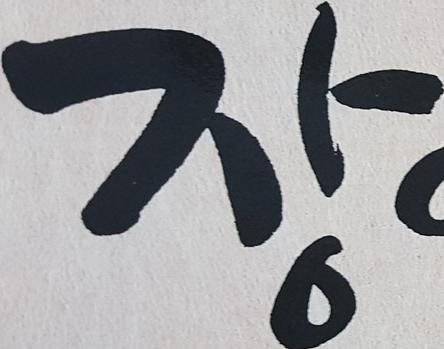

In [44]:
image_files = list(glob.glob(tiw_crop + '*'))
image_files = natsort.natsorted(image_files)  # 크롭된 이미지 리스트 정렬

Image.open(image_files[0])

In [41]:
csv_new_crop = pd.DataFrame([])
csv_new_crop['path'] = image_files
csv_new_crop['text'] = text

In [42]:
csv_new_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15580 entries, 0 to 15579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    15580 non-null  object
 1   text    15580 non-null  object
dtypes: object(2)
memory usage: 243.6+ KB


In [43]:
csv_new_crop

,path,text
0,./images/crop_tiw/train_data_0.jpg,장
1,./images/crop_tiw/train_data_1.jpg,아
2,./images/crop_tiw/train_data_2.jpg,찌
3,./images/crop_tiw/train_data_3.jpg,한
4,./images/crop_tiw/train_data_4.jpg,국
...,...,...
15575,./images/crop_tiw/train_data_15575.jpg,sj산림조합
15576,./images/crop_tiw/train_data_15576.jpg,더
15577,./images/crop_tiw/train_data_15577.jpg,조
15578,./images/crop_tiw/train_data_15578.jpg,은


In [45]:
# lmdb 데이터 생성을 위한 gt 파일 저장
csv_new_crop.to_csv(lmdb_gt + 'crop_data.txt', sep='\t', index=False, header=False)

### 2-2. [야외 실제 촬영 한글 이미지](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=105)

### 파일 경로, 이미지, 라벨 추출

In [46]:
def number_of_subfiles(data_dir):
    s = 0
    _path = []
    _list = []


    for (path, dir, files) in os.walk(data_dir):
        for filename in files:
            ext = os.path.splitext(filename)[-1]

            if ext != '.zip':
                index_number = filename.split('.')[0]
                _list.append(index_number)
                _path.append(path + '/' + filename)
                s += 1
        
    _list.sort()

    return s, _list, _path

In [47]:
cnt_img, ti_path, train_img = number_of_subfiles(hub_timg)
cnt_label, tl_path, train_label = number_of_subfiles(hub_tlabel)

cnt_img, cnt_label

(1000, 1000)

In [48]:
# 이미지와 라벨 매치가 안되는 파일이 있는지 개수 확인.
liset = set(ti_path)
li2set = set(tl_path)
black_list = set(liset | li2set) - set(liset & li2set)
black_list

set()

In [49]:
for b in black_list:
    for p in train_label:
        if p.split('.')[-2].split('/')[-1] == b:
            train_label.remove(p)

len(train_label)

1000

In [50]:
# natsorted를 이용해 1-> 10 -> 11 처럼 사전순 아닌 1 -> 2 -> ... -> 10 처럼 숫자크기 순으로 정렬
train_img = natsort.natsorted(train_img) 
train_label = natsort.natsorted(train_label)
train_img[:1000:100], train_label[:1000:100]

(['./images/hub_train//간판_가로형간판_000001.jpg',
  './images/hub_train//간판_가로형간판_000101.jpg',
  './images/hub_train//간판_가로형간판_000201.jpg',
  './images/hub_train//간판_가로형간판_000301.jpg',
  './images/hub_train//간판_가로형간판_000401.jpg',
  './images/hub_train//간판_가로형간판_000501.jpg',
  './images/hub_train//간판_가로형간판_000601.jpg',
  './images/hub_train//간판_가로형간판_000701.jpg',
  './images/hub_train//간판_가로형간판_000801.jpg',
  './images/hub_train//간판_가로형간판_000901.jpg'],
 ['./labels/hub_train//간판_가로형간판_000001.json',
  './labels/hub_train//간판_가로형간판_000101.json',
  './labels/hub_train//간판_가로형간판_000201.json',
  './labels/hub_train//간판_가로형간판_000301.json',
  './labels/hub_train//간판_가로형간판_000401.json',
  './labels/hub_train//간판_가로형간판_000501.json',
  './labels/hub_train//간판_가로형간판_000601.json',
  './labels/hub_train//간판_가로형간판_000701.json',
  './labels/hub_train//간판_가로형간판_000801.json',
  './labels/hub_train//간판_가로형간판_000901.json'])

In [51]:
# cnt_img, vi_path, valid_img = number_of_subfiles(hub_vimg)
# cnt_label, vl_path, valid_label = number_of_subfiles(hub_vlabel)

# cnt_img, cnt_label

In [52]:
# valid_img[:50], valid_label[:50]

### 이미지, 라벨 리스트 생성

In [53]:
train_json_list = []
# valid_json_list = []

for label in tqdm(train_label):
    with open(label, encoding='utf8') as f:
        train_json_list.append(json.load(f))

# for label in tqdm(valid_label):
#     with open(label, encoding='utf8') as f:
#         valid_json_list.append(json.load(f))

train_json_list.__len__(), #valid_json_list.__len__()

100%|██████████| 1000/1000 [00:00<00:00, 24202.98it/s]


(1000,)

### 데이터 전처리(Crop)

In [54]:
def mk_crop(json_list):
    idxs = []    # 파일 순서 인덱스
    lotate = []  # 이미지 좌표
    label = []   # 라벨

    for idx, i in tqdm(enumerate(json_list), total=len(json_list)):
        for jdx, j in enumerate(i['annotations']):

            # 좌표 이상치 제거
            if j['bbox'] == [None, None, None, None]:
                continue

            # 라벨 결측치 제거
            elif j['text'] == "xxx":
                continue

            idxs.append(idx)
            lotate.append(j['bbox'])
            label.append(j['text'])

    return idxs, lotate, label

In [55]:
t_idxs, t_lotate, t_label = mk_crop(train_json_list)
#v_idxs, v_lotate, v_label = mk_crop(valid_json_list)

100%|██████████| 1000/1000 [00:00<00:00, 172059.89it/s]


In [56]:
# crop을 위한 좌표 정보 수정
for i in trange(len(t_lotate)):
    t_lotate[i][2] = t_lotate[i][0] + t_lotate[i][2]
    t_lotate[i][3] = t_lotate[i][1] + t_lotate[i][3]

# for i in trange(len(v_lotate)):
#     v_lotate[i][2] = v_lotate[i][0] + v_lotate[i][2]
#     v_lotate[i][3] = v_lotate[i][1] + v_lotate[i][3]

100%|██████████| 1381/1381 [00:00<00:00, 450695.13it/s]


### train data 저장

In [58]:
alpha = 0.5  # 이미지 resize 비율
starts = 0  # 오류로 중단하기 전 마지막 인덱스

for idx, i in tqdm(enumerate(t_lotate), total=len(t_lotate)):
    idx += starts
    image = Image.open(train_img[t_idxs[idx]])
    crop_image = image.crop(i)

    # crop_image.resize((crop_image.size[0] * alpha, crop_image.size[1] * alpha))  # resize
    crop_image.save(hub_tcrop + f'train_data_{str(idx).zfill(7)}.jpg')

paths = sorted(glob.glob(hub_tcrop + '/t*.*'))

data = pd.DataFrame()
data['path'] = paths
data['label'] = t_label
data.to_csv(lmdb_gt + 'hub_tlabel.txt', sep='\t', encoding='utf8', index=False)


100%|██████████| 1381/1381 [00:21<00:00, 65.23it/s]


## 3. Dacon 데이터 전처리 및 lmdb 데이터 생성

### 3-1. train.csv 수정

In [69]:
# 라벨링이 잘못되어있거나 누락된 데이터 수정 -> train_edit.csv 로 저장
train_csv_path = 'train_edit.csv'
train_csv = pd.read_csv(train_csv_path)

# lmdb 데이터 생성을 위한 gt 파일 생성
train_csv[:-1000].to_csv('./lmdb_gt/train.txt', sep='\t', header=False, index=False)

# 최종 학습 단계의 모델 저장을 위한 임시 validation gt 파일 생성
train_csv[-1000:].to_csv('./lmdb_gt/valid.txt', sep='\t', header=False, index=False)

### 3-2. 학습에 사용할 lmdb 데이터 생성

In [73]:
'''
window 환경에서 작업 시의 lmdb 파일 생성 명령어:
!python ./hallymocr/create_lmdb_dataset.py --inputPath [데이터 root 경로] --gtFile [txt 파일 경로] --outputPath [데이터 저장 경로] --file_size [데이터 총 크기(GB)]

linux 환경에서 작업 시의 lmdb 파일 생성 명령어:
!python3 ./hallymocr/create_lmdb_dataset.py --inputPath [데이터 root 경로] --gtFile [txt 파일 경로] --outputPath [데이터 저장 경로] --file_size [데이터 총 크기(GB)]
'''
# !python ./hallymocr/create_lmdb_dataset.py --inputPath ./images/crop_valid --gtFile ./lmdb_data/hub_vlabel.txt --outputPath ./result/hvalid --file_size 5

print('한국어 글자체 (tiw) lmdb 생성')
!python ./hallymocr/create_lmdb_dataset.py --inputPath '' --gtFile ./lmdb_gt/crop_data.txt --outputPath ./result/tiw --file_size 10

print('야외 실제 촬영 데이터 lmdb 생성')
!python ./hallymocr/create_lmdb_dataset.py --inputPath '' --gtFile ./lmdb_gt/hub_tlabel.txt --outputPath ./result/htrain --file_size 20

print('Dacon 제공 데이터셋 ( : -1000 만큼 train 할당')
!python ./hallymocr/create_lmdb_dataset.py --inputPath '' --gtFile ./lmdb_gt/train.txt --outputPath ./result/train --file_size 5

print('Dacon 제공 데이터셋 ( -1000 :  만큼 valid 할당')
!python ./hallymocr/create_lmdb_dataset.py --inputPath '' --gtFile ./lmdb_gt/valid.txt --outputPath ./result/valid --file_size 2

한국어 글자체 (tiw) lmdb 생성
Written 1000 / 15580
Written 2000 / 15580
Written 3000 / 15580
Written 4000 / 15580
Written 5000 / 15580
Written 6000 / 15580
Written 7000 / 15580
Written 8000 / 15580
Written 9000 / 15580
Written 10000 / 15580
Written 11000 / 15580
Written 12000 / 15580
Written 13000 / 15580
Written 14000 / 15580
Written 15000 / 15580
Created dataset with 15580 samples
야외 실제 촬영 데이터 lmdb 생성
path does not exist
Written 1000 / 1382
Created dataset with 1381 samples
Dacon 제공 데이터셋 ( : -1000 만큼 train 할당
Written 1000 / 11159
Written 2000 / 11159
Written 3000 / 11159
Written 4000 / 11159
Written 5000 / 11159
Written 6000 / 11159
Written 7000 / 11159
Written 8000 / 11159
Written 9000 / 11159
Written 10000 / 11159
Written 11000 / 11159
Created dataset with 11159 samples
Dacon 제공 데이터셋 ( -1000 :  만큼 valid 할당
Written 1000 / 1000
Created dataset with 1000 samples


## 4. OCR 모델 학습
1차 학습은 외부데이터로만 학습을 진행(crop약 160만장)하며, validation set은 Dacon측에서 제공한 train셋을 사용합니다.

In [74]:
ko_txt = ''
e = ord('가')

for i in range(11172):
    ko_txt += chr(e + i)

ko_txt += ' '

In [75]:
import sys
import random
import string
import torch.backends.cudnn as cudnn
import torch.utils.data
import numpy as np

sys.path.append("./hallymocr")
from hallymocr.train import train
from hallymocr.test import test

In [84]:
# 1차 학습 하이퍼파라미터 설정
opt = {
    'exp_name': None,
    'train_data': './result/',
    'valid_data': './result/train', # 
    'manualSeed': 1111,
    'workers': 8,
    'batch_size': 32,
    'num_iter': 100000,
    'valInterval': 1000,
    'saved_model': '',

    'FT': False,
    'adam': False,
    'lr': 1,
    'beta1': 0.9,
    'rho': 0.95,
    'eps': 1e-8,
    'grad_clip': 5,
    'baiduCTC': False,
    'select_data': 'tiw-htrain',
    'batch_ratio': '0.5-0.5',
    'total_data_usage_ratio': '1',
    'batch_max_length': 15,

    'imgH': 256,
    'imgW': 256,
    'rgb': False,
    'character': ko_txt,
    'sensitive': False,
    'PAD': False,
    'data_filtering_off': False,
    'Transformation': 'TPS',  # None|TPS
    'FeatureExtraction': 'ResNet',  # VGG|ResNet|RCNN
    'SequenceModeling': 'BiLSTM',  # None|BiLSTM
    'Prediction': 'Attn',  # CTC|Attn
    'num_fiducial': 20,
    'input_channel': 1,
    'output_channel': 512,
    'hidden_size': 256,
}

# 모델 추가 세부사항 설정
if not opt['exp_name']:
    opt['exp_name'] = '{Transformation}-{FeatureExtraction}-{SequenceModeling}-{Prediction}'.format(**opt)
    opt['exp_name'] += '-Seed{manualSeed}'.format(**opt)
    # print(opt.exp_name)

os.makedirs('./saved_models/{exp_name}'.format(**opt), exist_ok=True)

""" Seed and GPU setting """
random.seed(opt['manualSeed'])
np.random.seed(opt['manualSeed'])
torch.manual_seed(opt['manualSeed'])
torch.cuda.manual_seed(opt['manualSeed'])

cudnn.benchmark = True
cudnn.deterministic = True
opt['num_gpu'] = torch.cuda.device_count()

if opt['num_gpu'] > 1:
    print('------ Use multi-GPU setting ------')
    print('if you stuck too long time with multi-GPU setting, try to set --workers 0')
    opt['workers'] = opt['workers'] * opt['num_gpu']
    opt['batch_size'] = opt['batch_size'] * opt['num_gpu']

------ Use multi-GPU setting ------
if you stuck too long time with multi-GPU setting, try to set --workers 0


### 모델 훈련

In [85]:
# train
train(opt)

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: ./result/
opt.select_data: ['tiw', 'htrain']
opt.batch_ratio: ['0.5', '0.5']
--------------------------------------------------------------------------------
dataset_root:    ./result/	 dataset: tiw
sub-directory:	/tiw	 num samples: 8923
num total samples of tiw: 8923 x 1 (total_data_usage_ratio) = 8923
num samples of tiw per batch: 256 x 0.5 (batch_ratio) = 128


Exception ignored in: <function _releaseLock at 0x7f44d11c5a60>
Traceback (most recent call last):
  File "/home/mmc/anaconda3/envs/OCR/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


--------------------------------------------------------------------------------
dataset_root:    ./result/	 dataset: htrain
sub-directory:	/htrain	 num samples: 1368
num total samples of htrain: 1368 x 1 (total_data_usage_ratio) = 1368
num samples of htrain per batch: 256 x 0.5 (batch_ratio) = 128
--------------------------------------------------------------------------------
Total_batch_size: 128+128 = 256
--------------------------------------------------------------------------------
dataset_root:    ./result/train	 dataset: /
sub-directory:	/.	 num samples: 11120
--------------------------------------------------------------------------------
model input parameters 256 256 20 1 512 256 11175 15 TPS ResNet BiLSTM Attn
Skip Transformation.LocalizationNetwork.localization_fc2.weight as it is already initialized
Skip Transformation.LocalizationNetwork.localization_fc2.bias as it is already initialized
Model:
DataParallel(
  (module): Model(
    (Transformation): TPS_SpatialTransforme

  0%|          | 1/100000 [01:08<1912:59:16, 68.87s/it]

[1/100000] Train loss: 9.31987, Valid loss: 9.30058, Elapsed_time: 2.21333
Current_accuracy : 0.000, Current_norm_ED  : 0.00
Best_accuracy    : 0.000, Best_norm_ED     : 0.00
--------------------------------------------------------------------------------
Ground Truth              | Prediction                | Confidence Score & T/F
--------------------------------------------------------------------------------
서른                        | 촂촂쳝쳝맨맨맨맨맨맨맨맨맨맨쳝           | 0.0000	False
소프트스틸                     | 촂촂촂촂촂촂촂촂촂퇉퇉퇉퇉꾖촂           | 0.0000	False
공인중개사                     | 촂촂촂흰흰흰붉붉뢏붉퇉뢏붉붉퇉           | 0.0000	False
토건                        | 촂촂촂쵏뷙붉럃붉뢏붉럃뢏붉뢏붉           | 0.0000	False
고기손 생갈비                   | 촂촂촂놧놧놧맨맨맨맨맨맨맨맨맨           | 0.0000	False
--------------------------------------------------------------------------------


  0%|          | 11/100000 [01:30<74:38:10,  2.69s/it] Exception ignored in: <function _releaseLock at 0x7f44d11c5a60>
Traceback (most recent call last):
  File "/home/mmc/anaconda3/envs/OCR/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  0%|          | 20/100000 [02:07<68:11:35,  2.46s/it] 

### Dacon 데이터로 2차 학습
외부데이터로 학습된 1차 학습에서 가장 좋은 정확도를 보인 모델을 불러와 </br>
오타, 띄어쓰기, 이상값 등을 수작업으로 정제한 Dacon Train파일을 학습데이터로 사용하여 추가학습을 진행합니다. </br>
이때 train셋은 Dacon Train셋의 -1000번째 까지이며 validation은 Dacon Train셋의 끝에서 1000번째 까지의 데이터를 사용합니다.

In [80]:
opt['exp_name'] = '{Transformation}-{FeatureExtraction}-{SequenceModeling}-{Prediction}-Seed{manualSeed}'.format(**opt)
opt['saved_model'] = 'saved_models/{Transformation}-{FeatureExtraction}-{SequenceModeling}-{Prediction}-Seed{manualSeed}/best_accuracy.pth'.format(**opt)
opt['num_iter'] = 1000
opt['lr'] = 0.001
opt['select_data'] = 'train'
opt['valid_data'] = './result/valid'
opt['batch_ratio'] = '1'

In [81]:
train(opt)

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: ./result/
opt.select_data: ['train']
opt.batch_ratio: ['1']
--------------------------------------------------------------------------------
dataset_root:    ./result/	 dataset: train
sub-directory:	/train	 num samples: 11120
sub-directory:	/htrain	 num samples: 1368
num total samples of train: 12488 x 1 (total_data_usage_ratio) = 12488
num samples of train per batch: 256 x 1.0 (batch_ratio) = 256
--------------------------------------------------------------------------------
Total_batch_size: 256 = 256
--------------------------------------------------------------------------------
dataset_root:    ./result/train	 dataset: /
sub-directory:	/.	 num samples: 11120
--------------------------------------------------------------------------------
model in

  0%|          | 1/1000 [01:08<19:04:11, 68.72s/it]

[1/1000] Train loss: 9.24676, Valid loss: 9.29475, Elapsed_time: 3.20164
Current_accuracy : 0.000, Current_norm_ED  : 0.00
Best_accuracy    : 0.000, Best_norm_ED     : 0.00
--------------------------------------------------------------------------------
Ground Truth              | Prediction                | Confidence Score & T/F
--------------------------------------------------------------------------------
동물병원                      | 촂촂촂촂흰맨맨맨맨맨맨맨맨맨맨           | 0.0000	False
이상국                       | 퇷팎뷙뷙뷙뷙팎팎뷙꽥뷙퇉퇉퇉맣           | 0.0000	False
경희                        | 갢퇷퇷맨퇷퇷옃퇷옃퇷옃샯옃샯옃           | 0.0000	False
마사지                       | 퇷퇷뷙뷙뷙뢏붉뢏붉팎탆탆붉뢏붉           | 0.0000	False
구                         | 쵏팎팎팎퇷퇷팎맨퇷맨퇷맨퇷맨퇷           | 0.0000	False
--------------------------------------------------------------------------------


  1%|          | 8/1000 [01:26<2:59:00, 10.83s/it] 


KeyboardInterrupt: 

## 5. 최종 결과

### 모델 예측

In [82]:
# 저장된 모델 load
opt['saved_model'] = 'saved_models/{Transformation}-{FeatureExtraction}-{SequenceModeling}-{Prediction}-Seed{manualSeed}/best_accuracy.pth'.format(**opt)
opt['test_data'] = './test'

In [83]:
result = test(opt)

model input parameters 256 256 20 1 512 256 11175 15 TPS ResNet BiLSTM Attn
loading pretrained model from saved_models/TPS-ResNet-BiLSTM-Attn-Seed1111/best_accuracy.pth


### CSV 파일 생성

In [ ]:
result_csv_path = 'open/sample_submission.csv'
result_csv = pd.read_csv(result_csv_path)

result_csv['text'] = result

In [ ]:
from datetime import datetime

time = datetime.now().strftime('%m%d_%H%M')
csv_name = f'{time}.csv'
result_csv.to_csv(csv_name, index=False, encoding='utf8')

In [ ]:
pd.read_csv(csv_name)